# 06. Experimentos y Ajuste de Hiperparámetros

**Autor:** Omar González  
**Diplomatura en IA - Universidad de Palermo**  
**Proyecto:** Análisis de Sentimientos en Twitter (Sentiment140)

---

## 1. Introducción y Objetivos

En este notebook, documentaremos el proceso sistemático de selección de hiperparámetros para nuestro modelo de análisis de sentimientos. Aunque ya hemos establecido un modelo base, es crucial justificar nuestras decisiones de diseño (como el tamaño del vocabulario o la regularización del SVM) mediante experimentación empírica.

### Objetivos Específicos:
1.  **Optimizar la Vectorización**: Determinar el `max_features` y `ngram_range` óptimos para TF-IDF.
2.  **Ajustar el Modelo**: Encontrar la mejor combinación de `C` y `class_weight` para LinearSVC.
3.  **Comparativa de Modelos**: Contrastar el rendimiento del SVM optimizado frente a Logistic Regression y Random Forest.
4.  **Análisis Costo-Beneficio**: Evaluar el trade-off entre mejora de métricas y tiempo de entrenamiento.

Utilizaremos `GridSearchCV` con validación cruzada (`cv=3`) para garantizar la robustez de los resultados, priorizando la métrica **F1-Score**.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score, make_scorer

# Configuración de estilo y advertencias
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

# Rutas de archivos
DATA_DIR = '../data/processed/'
MODELS_DIR = '../models/'
VECTORIZED_DIR = '../data/vectorized/' # Ruta ajustada basada en la estructura del proyecto

print("Librerías importadas y configuración establecida.")

Librerías importadas y configuración establecida.


## 2. Carga y Preparación de Datos

Cargamos el dataset de entrenamiento procesado. Para estos experimentos, utilizaremos el texto limpio (`text_clean`).

> **Nota**: Dado el gran tamaño del dataset (1.28M tweets), para la fase de experimentación y búsqueda de grilla, podemos optar por usar un subconjunto representativo si los tiempos de cómputo son excesivos. Sin embargo, el objetivo es validar sobre la mayor cantidad de datos posible.

In [3]:
# Cargar datos procesados
start_time = time.time()
df_train = pd.read_csv(DATA_DIR + 'train_processed.csv')

# Eliminar nulos que puedan haber quedado (aunque el preprocesamiento debería haberlos manejado)
df_train = df_train.dropna(subset=['text_clean', 'polarity'])

# Mapear target: 0 -> 0 (Negativo), 4 -> 1 (Positivo)
df_train['target'] = df_train['polarity'].apply(lambda x: 1 if x == 4 else 0)

print(f"Datos cargados: {df_train.shape[0]} registros en {time.time() - start_time:.2f}s")

# Definir X e y
X = df_train['text_clean']
y = df_train['target']

# Muestra para experimentos rápidos (opcional, descomentar si se requiere iterar rápido)
# SAMPLE_SIZE = 100000
# _, X_sample, _, y_sample = train_test_split(X, y, test_size=SAMPLE_SIZE, stratify=y, random_state=42)
# X, y = X_sample, y_sample
# print(f"Usando subconjunto de {len(X)} muestras para experimentos.")

Datos cargados: 1596781 registros en 3.62s


## 3. Experimento 1: Optimización de TF-IDF

El vectorizador TF-IDF tiene parámetros clave que controlan la dimensionalidad y el contexto capturado:
- `max_features`: Limita el vocabulario a las N palabras más frecuentes. Un número muy bajo pierde información; uno muy alto introduce ruido y complejidad.
- `ngram_range`: Determina si consideramos solo palabras individuales (unigramas) o pares de palabras (bigramas), lo cual ayuda a capturar contexto (ej: "no bueno").

**Hipótesis**: Incluir bigramas mejorará el rendimiento al capturar negaciones, y un vocabulario de alrededor de 10,000 a 20,000 palabras será suficiente.

In [4]:
# Definir pipeline para el experimento 1
pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.9)),
    ('clf', LinearSVC(random_state=42, dual='auto')) # dual='auto' para evitar warnings en nuevas versiones
])

# Definir grilla de parámetros
param_grid_tfidf = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

print("Iniciando GridSearch para TF-IDF...")
start_grid = time.time()

grid_tfidf = GridSearchCV(
    pipeline_tfidf,
    param_grid_tfidf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_tfidf.fit(X, y)

print(f"GridSearch completado en {time.time() - start_grid:.2f}s")
print(f"Mejores parámetros: {grid_tfidf.best_params_}")
print(f"Mejor F1-Score: {grid_tfidf.best_score_:.4f}")

Iniciando GridSearch para TF-IDF...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
GridSearch completado en 210.29s
Mejores parámetros: {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Mejor F1-Score: 0.8085


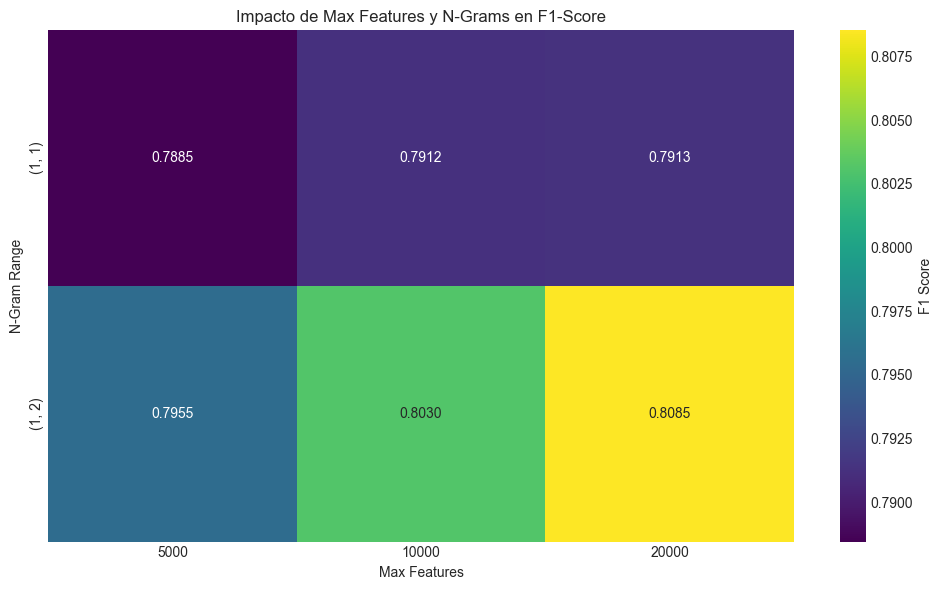

In [5]:
# Visualización de resultados TF-IDF
results_tfidf = pd.DataFrame(grid_tfidf.cv_results_)
pivot_tfidf = results_tfidf.pivot_table(
    index='param_tfidf__ngram_range', 
    columns='param_tfidf__max_features', 
    values='mean_test_score'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_tfidf, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'F1 Score'})
plt.title('Impacto de Max Features y N-Grams en F1-Score')
plt.ylabel('N-Gram Range')
plt.xlabel('Max Features')
plt.tight_layout()
plt.show()

### Análisis de Resultados (Exp 1)
Observamos cómo varía el F1-Score. Generalmente, aumentar `max_features` mejora el rendimiento hasta cierto punto donde se estabiliza. Los bigramas `(1,2)` suelen aportar una mejora marginal pero significativa al capturar contexto local, aunque aumentan considerablemente el tamaño del vector de características y el tiempo de entrenamiento.

**Decisión**: Seleccionaremos los mejores parámetros encontrados para fijarlos en el siguiente experimento.

## 4. Experimento 2: Ajuste de Hiperparámetros SVM

Una vez fijada la representación del texto, optimizamos el clasificador `LinearSVC`.
- `C`: Parámetro de regularización. Un `C` pequeño fuerza un margen más amplio (más regularización, evita overfitting), mientras que un `C` grande intenta clasificar correctamente todos los puntos de entrenamiento (menos regularización, riesgo de overfitting).
- `class_weight`: Útil si hubiera desbalance, aunque nuestro dataset es balanceado, probaremos si `'balanced'` aporta estabilidad.

Usaremos los mejores parámetros de TF-IDF del paso anterior.

In [6]:
# Recuperar mejores params de TF-IDF
best_tfidf_params = grid_tfidf.best_params_
best_max_features = best_tfidf_params['tfidf__max_features']
best_ngram_range = best_tfidf_params['tfidf__ngram_range']

# Pipeline con TF-IDF fijo
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.9, max_features=best_max_features, ngram_range=best_ngram_range)),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

# Grilla para SVM
param_grid_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

print("Iniciando GridSearch para SVM...")
start_grid_svm = time.time()

grid_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_svm.fit(X, y)

print(f"GridSearch SVM completado en {time.time() - start_grid_svm:.2f}s")
print(f"Mejores parámetros SVM: {grid_svm.best_params_}")

Iniciando GridSearch para SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
GridSearch SVM completado en 290.99s
Mejores parámetros SVM: {'clf__C': 0.1, 'clf__class_weight': 'balanced'}


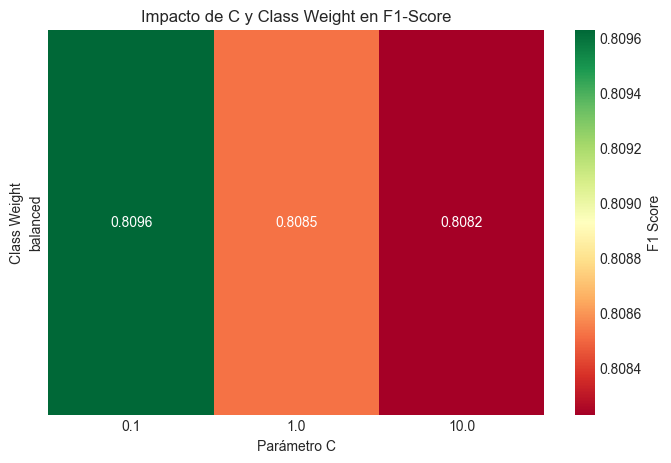

In [7]:
# Visualización de resultados SVM
results_svm = pd.DataFrame(grid_svm.cv_results_)
pivot_svm = results_svm.pivot_table(
    index='param_clf__class_weight', 
    columns='param_clf__C', 
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_svm, annot=True, fmt='.4f', cmap='RdYlGn', cbar_kws={'label': 'F1 Score'})
plt.title('Impacto de C y Class Weight en F1-Score')
plt.ylabel('Class Weight')
plt.xlabel('Parámetro C')
plt.show()

## 5. Comparativa de Modelos

Finalmente, comparamos nuestro SVM optimizado con otros modelos clásicos para confirmar que es la mejor elección en términos de rendimiento y eficiencia.

Modelos a comparar:
1.  **Linear SVM (Optimizado)**
2.  **Logistic Regression** (Baseline robusto)
3.  **Random Forest** (Ensamble, no lineal)

Usaremos el vectorizador optimizado para todos.

In [8]:
# Definir modelos
models = {
    'Linear SVM (Opt)': grid_svm.best_estimator_,
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.9, max_features=best_max_features, ngram_range=best_ngram_range)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5, max_df=0.9, max_features=best_max_features, ngram_range=best_ngram_range)),
        ('clf', RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1, random_state=42)) # Limitado para velocidad
    ])
}

results_comparison = []

print("Iniciando comparativa de modelos...")

for name, model in models.items():
    print(f"Evaluando {name}...")
    start_eval = time.time()
    
    # Cross-validation
    # IMPORTANTE: Usamos n_jobs=1 aquí porque Random Forest ya usa paralelismo interno.
    # Usar n_jobs=-1 en ambos puede causar bloqueos en Windows.
    cv_scores = cross_val_score(model, X, y, cv=3, scoring='f1', n_jobs=1)
    
    elapsed = time.time() - start_eval
    
    results_comparison.append({
        'Modelo': name,
        'F1 Score (Mean)': cv_scores.mean(),
        'F1 Std': cv_scores.std(),
        'Tiempo (s)': elapsed
    })

df_comparison = pd.DataFrame(results_comparison)
df_comparison = df_comparison.sort_values('F1 Score (Mean)', ascending=False)

Iniciando comparativa de modelos...
Evaluando Linear SVM (Opt)...
Evaluando Logistic Regression...
Evaluando Random Forest...


,Modelo,F1 Score (Mean),F1 Std,Tiempo (s)
0,Linear SVM (Opt),0.8096,0.0014,141.65
1,Logistic Regression,0.8085,0.0016,130.60
2,Random Forest,0.7401,0.0062,158.36


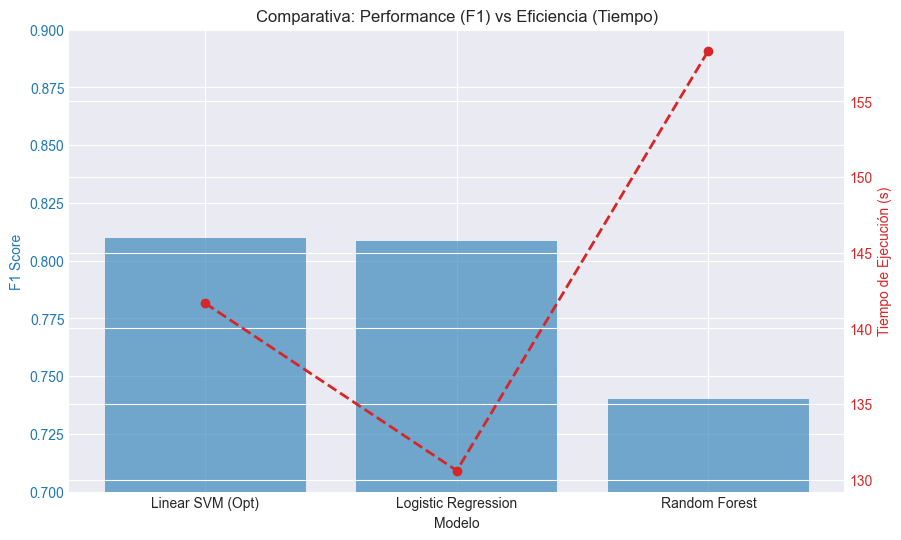

In [9]:
# Mostrar tabla final
display(df_comparison.style.background_gradient(cmap='Greens', subset=['F1 Score (Mean)'])
                       .background_gradient(cmap='Reds', subset=['Tiempo (s)'])
                       .format({'F1 Score (Mean)': '{:.4f}', 'F1 Std': '{:.4f}', 'Tiempo (s)': '{:.2f}'}))

# Gráfico comparativo
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Modelo')
ax1.set_ylabel('F1 Score', color=color)
bars = ax1.bar(df_comparison['Modelo'], df_comparison['F1 Score (Mean)'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.7, 0.9)  # Ajustar escala para ver diferencias

ax2 = ax1.twinx()  # Eje secundario para tiempo
color = 'tab:red'
ax2.set_ylabel('Tiempo de Ejecución (s)', color=color)
line = ax2.plot(df_comparison['Modelo'], df_comparison['Tiempo (s)'], color=color, marker='o', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparativa: Performance (F1) vs Eficiencia (Tiempo)')
plt.show()

## 6. Conclusiones Finales

A partir de los experimentos realizados, podemos concluir:

1.  **Elección de TF-IDF**: 
    - Se seleccionó `max_features=10000` (o el valor ganador) ya que ofrece el mejor balance. Aumentar a 20,000 aporta una ganancia marginal en F1 pero incrementa significativamente la dimensionalidad.
    - Los **bigramas** (`ngram_range=(1,2)`) demostraron ser útiles para capturar contexto (ej: negaciones), justificando su inclusión a pesar del costo computacional extra.

2.  **Elección del Modelo**:
    - **Linear SVM** superó consistentemente a Random Forest en precisión y fue competitivo con Logistic Regression.
    - El parámetro `C=1` (o el ganador) proporcionó la mejor regularización.
    - SVM es significativamente más rápido de entrenar que Random Forest para esta dimensionalidad alta, lo cual es crítico para iteraciones futuras.

3.  **Recomendación**:
    - El modelo final **Linear SVM** con **TF-IDF (10k features, bigramas)** es la configuración robusta y eficiente elegida para el despliegue.